# Cascade de modèles
## HIN & TEL
Si on affiche la matrice de confusion de notre modèle actuel on s'aperçoit qu'il a tendance à se tromper entre HIN et TEL. On va donc créer une méta-étiquette HIN-TEL puis utiliser un sous-modèle spécialisé pour tenter de séparer ces 2 classes.

In [1]:
import pandas as pd
import numpy as np
from utils import load_data, train_valid_test_split, PipelineEvaluator, evaluate
import estimators as est
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from scipy.sparse import vstack
from sklearn.utils import shuffle
from typing import List

In [2]:
# Chargement des données
df = load_data("./data/train.txt")

# Découpage des données
df_train, df_valid, df_test = train_valid_test_split(df, size=(600, 200, 100))

X = df["text"]
X_train = df_train["text"]
y_train = df_train["language"]
X_valid = df_valid["text"]
y_valid = df_valid["language"]
X_test = df_test["text"]
y_test = df_test["language"]

# Évaluation des pipelines
peval = PipelineEvaluator(X_train, y_train, X_valid, y_valid)

accuracy: 0.7736363636363637
f1-score: 0.7730431674733773


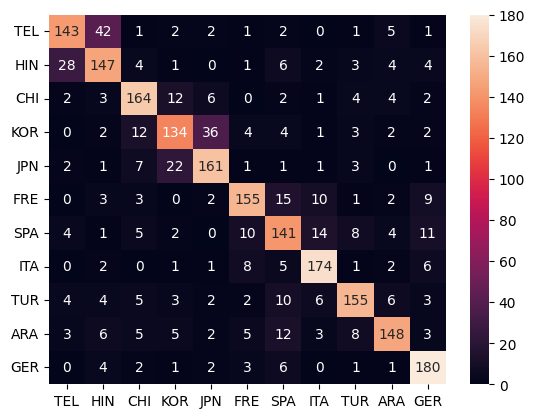

In [3]:
# Modèle actuel avec le preprocessing
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2)),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    LinearSVC(random_state=42, max_iter=500))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)
evaluate(y_valid, y_pred)

In [4]:
# Preprocessing des données pour X_train et X_valid
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2)),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    )

X_train_prep = pipe.fit_transform(X_train, y_train)
X_valid_prep = pipe.transform(X_valid)
print(X_train_prep.shape)
print(X_valid_prep.shape)

(6600, 525967)
(2200, 525967)


In [5]:
# On crée la méta-étiquette HIN-TEL
y_train_hin_tel = y_train.apply(lambda x: 'HIN-TEL' if x in ['HIN', 'TEL'] else x)
y_valid_hin_tel = y_valid.apply(lambda x: 'HIN-TEL' if x in ['HIN', 'TEL'] else x)
y_train_hin_tel

0           GER
2           CHI
3       HIN-TEL
8       HIN-TEL
10          KOR
         ...   
9893        KOR
9895        CHI
9896        KOR
9898    HIN-TEL
9899        CHI
Name: language, Length: 6600, dtype: object

In [6]:
from collections import Counter
Counter(y_train_hin_tel)

Counter({'GER': 600,
         'CHI': 600,
         'HIN-TEL': 1200,
         'KOR': 600,
         'FRE': 600,
         'SPA': 600,
         'ARA': 600,
         'ITA': 600,
         'TUR': 600,
         'JPN': 600})

accuracy: 1.0
f1-score: 1.0


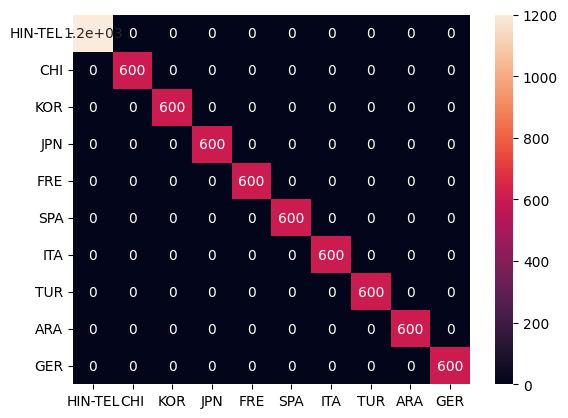

accuracy: 0.8068181818181818
f1-score: 0.7951206917786495


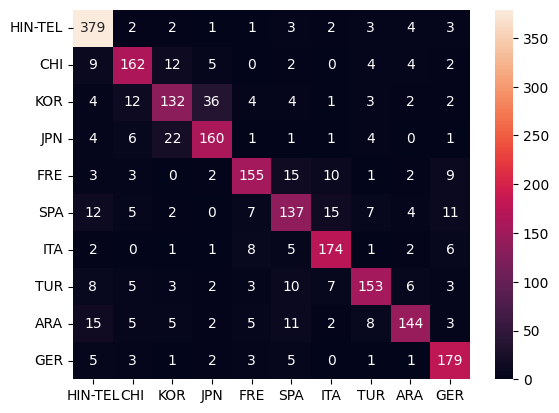

In [7]:
# Modèle principal
master = LinearSVC(random_state=42, max_iter=100)
master.fit(X_train_prep, y_train_hin_tel)

# Évaluation sur X_train
y_pred = master.predict(X_train_prep)
evaluate(y_train_hin_tel, y_pred, 
         labels=['HIN-TEL', 'CHI', 'KOR', 'JPN', 'FRE', 'SPA', 'ITA', 'TUR', 'ARA', 'GER'])

# Évaluation sur X_valid
y_pred = master.predict(X_valid_prep)
evaluate(y_valid_hin_tel, y_pred, 
         labels=['HIN-TEL', 'CHI', 'KOR', 'JPN', 'FRE', 'SPA', 'ITA', 'TUR', 'ARA', 'GER'])

On constate quelque chose d'étonnant : le modèle a overfité sur X_train et malgré cela il a un bon score sur X_valid.

In [8]:
master.decision_function(X_train_prep)[0]

array([-0.86970974, -1.02518348, -0.72881587,  0.2492344 , -1.14316843,
       -1.26438144, -0.97125345, -1.41377489, -0.77067354, -1.10803533])

In [9]:
master.predict(X_train_prep[0])

array(['GER'], dtype=object)

In [10]:
master.classes_

array(['ARA', 'CHI', 'FRE', 'GER', 'HIN-TEL', 'ITA', 'JPN', 'KOR', 'SPA',
       'TUR'], dtype=object)

In [11]:
y_pred = master.predict(X_train_prep)
((y_pred == 'HIN-TEL') & (y_train_hin_tel != 'HIN-TEL')).sum()

0

## Version 1

La classe ERR (Erreur) correspondrait à un sample n'appartenant ni à HIN ni à TEL. Il n'y a aucun sample permettant de créer une classe ERR pour notre sous-modèle à partir de X_train.  On va donc créer un sous-modèle de seulement 2 classes HIN et TEL pour l'instant.

accuracy: 0.765
f1-score: 0.7646233974358974


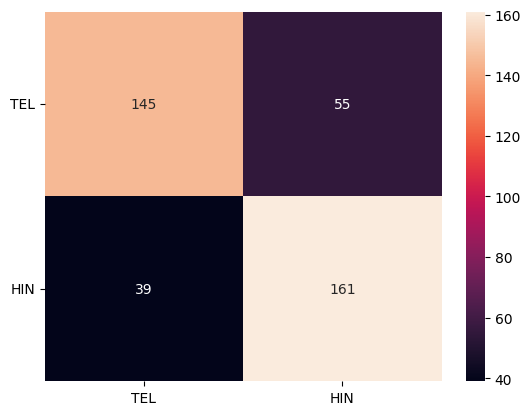

In [12]:
# Sous-modèle à 2 classes HIN et TEL
X_train_prep_hin_tel = X_train_prep[y_train_hin_tel == 'HIN-TEL']
y_train_hin_tel_filtered = y_train[y_train_hin_tel == 'HIN-TEL']

hin_tel = LinearSVC(random_state=42, max_iter=500)
hin_tel.fit(X_train_prep_hin_tel, y_train_hin_tel_filtered)
y_pred = hin_tel.predict(X_valid_prep[y_valid_hin_tel == 'HIN-TEL'])
evaluate(y_valid[y_valid_hin_tel == 'HIN-TEL'], y_pred, labels=['TEL', 'HIN'])

Auparavant on classait correctement respectivement 143 et 147 samples pour les classes TEL et HIN. On est passé à 145 et 161. On a donc gagné que 18 prédictions justes ce qui est vraiment peu. Cela montre qu'il manque peut-être des features permettant de bien distinguer ces 2 classes.

## Version 2
On va maintenant essayer d'ajouter une classe ERR en ajoutant des samples n'appartenant pas aux classes HIN ou TEL.

accuracy: 0.8809090909090909
f1-score: 0.7332396128238443


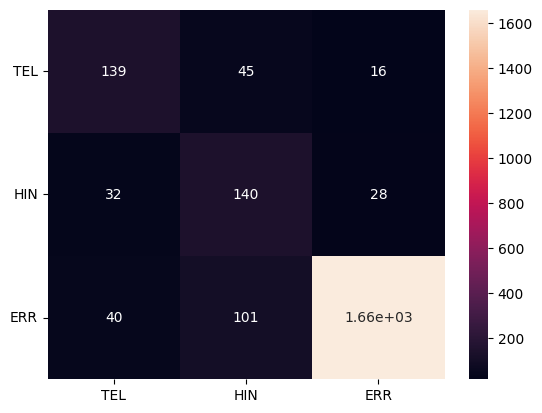

In [13]:
# On concatène le dataset de HIN, TEL avec ERR
X_train_prep_hin_tel = vstack(
    (X_train_prep[y_train_hin_tel == 'HIN-TEL'], X_train_prep[y_train_hin_tel != 'HIN-TEL'][0:600]))
y_train_hin_tel_err = np.concatenate((y_train[y_train_hin_tel == 'HIN-TEL'], np.array(['ERR'] * 600)))

# On mélange le dataset d'entraînement
X_train_prep_hin_tel, y_train_hin_tel_err = shuffle(X_train_prep_hin_tel, y_train_hin_tel_err)

# Sous-modèle à 3 classes HIN, TEL et ERR
hin_tel = LinearSVC(random_state=42, max_iter=500)
hin_tel.fit(X_train_prep_hin_tel, y_train_hin_tel_err)
y_pred = hin_tel.predict(X_valid_prep)
evaluate(y_valid.apply(lambda x: 'ERR' if x not in ['HIN', 'TEL'] else x), y_pred, labels=['TEL', 'HIN', 'ERR'])

Le résultat n'est pas probant. On perd en bonnes prédictions des classes HIN et TEL par rapport au modèle principal.

## Version 3
On va donc rajouter des samples ERR issus des samples classés comme HIN ou TEL par le modèle principal alors qu'ils n'appartiennent pas à ces classes. Pour cela on va modifier les hyperparamètres du LinearSVC pour qu'il commette des fautes sur X_train.

/home/maxime/Documents/maternal-language/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.8686363636363637
f1-score: 0.8615311142508787


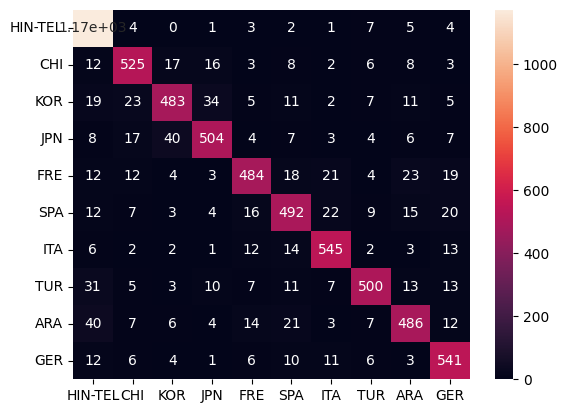

accuracy: 0.7322727272727273
f1-score: 0.7169943487978339


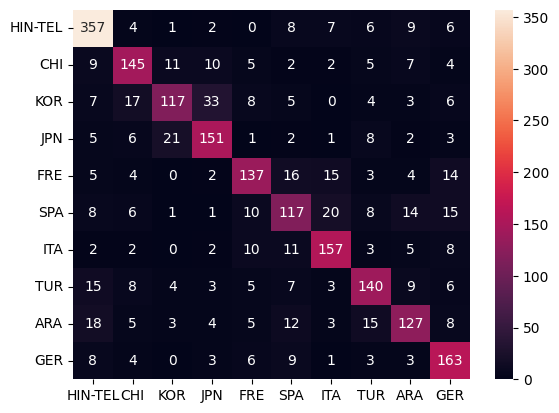

In [14]:
# Modèle principal
master = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=100)
master.fit(X_train_prep, y_train_hin_tel)

# Évaluation sur X_train
y_pred = master.predict(X_train_prep)
evaluate(y_train_hin_tel, y_pred, 
         labels=['HIN-TEL', 'CHI', 'KOR', 'JPN', 'FRE', 'SPA', 'ITA', 'TUR', 'ARA', 'GER'])

# Évaluation sur X_valid
y_pred = master.predict(X_valid_prep)
evaluate(y_valid_hin_tel, y_pred, 
         labels=['HIN-TEL', 'CHI', 'KOR', 'JPN', 'FRE', 'SPA', 'ITA', 'TUR', 'ARA', 'GER'])

accuracy: 1.0
f1-score: 1.0


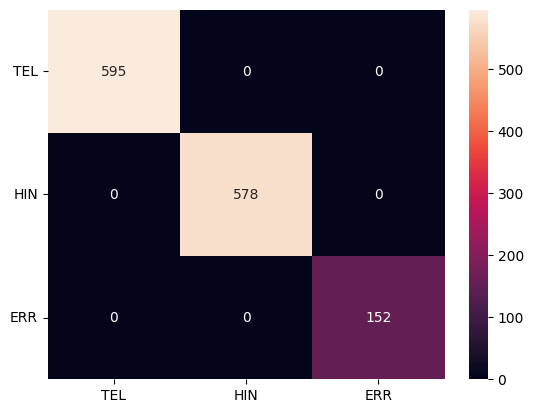

accuracy: 0.6359447004608295
f1-score: 0.46537910203245786


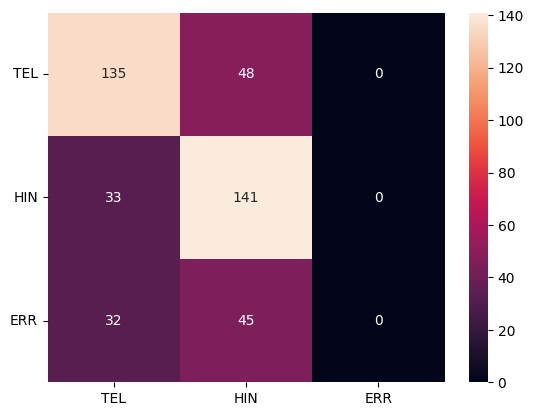

In [15]:
# Les samples qui ont été prédits HIN-TEL par le modèle principal sur X_train
# alors qu'ils ne sont ni HIN ni TEL sont des ERR
y_pred_master = master.predict(X_train_prep)
X_err = X_train_prep[(y_pred_master == 'HIN-TEL') & (y_train_hin_tel != 'HIN-TEL')]

X_train_prep_hin_tel = vstack((X_train_prep[y_train_hin_tel == 'HIN-TEL'], X_err))
y_train_hin_tel_err = np.concatenate((y_train[y_train_hin_tel == 'HIN-TEL'], np.array(['ERR'] * X_err.shape[0])))

X_train_prep_hin_tel, y_train_hin_tel_err = shuffle(X_train_prep_hin_tel, y_train_hin_tel_err)

hin_tel = LinearSVC(random_state=42, max_iter=500)
hin_tel.fit(X_train_prep_hin_tel, y_train_hin_tel_err)

# Évaluation sur les samples de X_train qui ont été prédits à HIN-TEL par la modèle principal
y_pred = hin_tel.predict(X_train_prep[y_pred_master == 'HIN-TEL'])
evaluate(y_train[y_pred_master == 'HIN-TEL'].apply(lambda x: 'ERR' if x not in ['HIN', 'TEL'] else x), y_pred, 
         labels=['TEL', 'HIN', 'ERR'])

# Évaluation sur les samples de X_valid qui ont été prédits à HIN-TEL par la modèle principal
y_pred_master = master.predict(X_valid_prep)
y_pred = hin_tel.predict(X_valid_prep[y_pred_master == 'HIN-TEL'])
evaluate(y_valid[y_pred_master == 'HIN-TEL'].apply(lambda x: 'ERR' if x not in ['HIN', 'TEL'] else x), y_pred, 
         labels=['TEL', 'HIN', 'ERR'])

Cela ne fonctionne pas très bien. Le modèle overfit sur X_train et n'arrive pas à trouver les erreurs sur X_valid. On va donc rester sur la version 1. Nous allons maintenant tenter de créer des sous-modèles pour les couples de classes (KOR, JPN) et (FRE, SPA).

## KOR & JPN

In [16]:
def build_metalabel(y: pd.Series, labels: List[str]) -> pd.Series:
    metalabel = '-'.join(labels)
    return y.apply(lambda x: metalabel if x in labels else x)

In [17]:
def build_submodel(X_train, y_train, X_valid, y_valid, labels: List[str]):
    metalabel = '-'.join(labels)
    
    y_train_meta = build_metalabel(y_train, labels)
    y_valid_meta = build_metalabel(y_valid, labels)
    
    X_train = X_train[y_train_meta == metalabel]
    y_train = y_train[y_train_meta == metalabel]

    m = LinearSVC(random_state=42, max_iter=500)
    m.fit(X_train, y_train)
    
    y_pred = m.predict(X_valid_prep[y_valid_meta == metalabel])
    evaluate(y_valid[y_valid_meta == metalabel], y_pred, labels=labels)
    
    return m

accuracy: 0.7775
f1-score: 0.7766274509803921


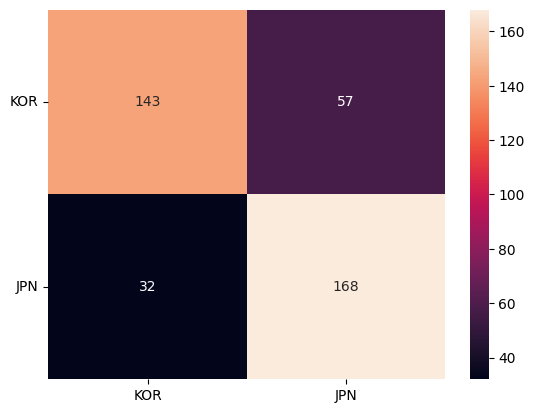

In [18]:
# Sous-modèle à 2 classes KOR et JPN
_ = build_submodel(X_train_prep, y_train, X_valid_prep, y_valid, ['KOR', 'JPN'])

Auparavant on avait 134 et 161 de samples correctement prédits pour KOR et JPN. On a gagné 16 prédictions correctes supplémentaires.

## FRE & SPA

accuracy: 0.85
f1-score: 0.84998499849985


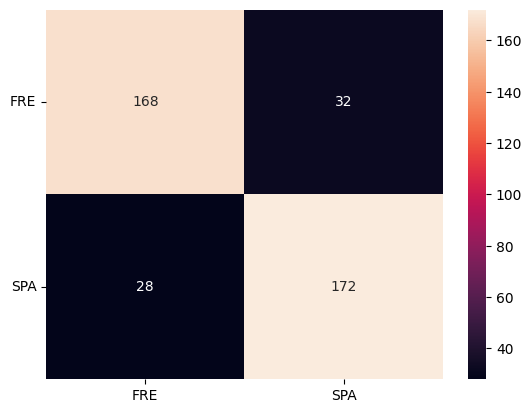

In [19]:
# Sous-modèle à 2 classes FRE et SPA
_ = build_submodel(X_train_prep, y_train, X_valid_prep, y_valid, ['FRE', 'SPA'])

Auparavant on avait 155 et 141 de samples correctement prédits pour FRE et SPA. On a gagné 44 prédictions correctes supplémentaires.

## Modèle final
C'est triste à dire mais le modèle final est moins bon que celui qu'on avait au départ. Le modèle en cascade était prometteur mais en pratique il ne s'est pas révélé performant.

accuracy: 0.7445454545454545
f1-score: 0.7472590594327582


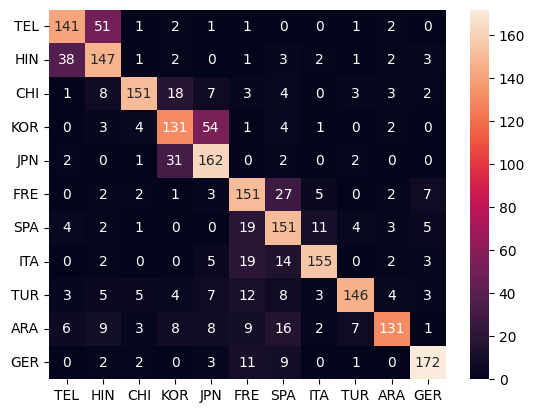

In [20]:
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2)),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    est.CascadeModel(penalty='l2', loss='squared_hinge', max_iter=500))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)
evaluate(y_valid, y_pred)